### Notebook for the deconvolution of 10X Visium heart LV sample using `cell2location`

- **Developed by**: Carlos Talavera-López Ph.D
- **Institute of Computational Biology - COmputational Health Centre - Helmholtz Munchen**
- v230114

### Load required modules

In [1]:
import scvi
import anndata
import numpy as np
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0
/home/cartalop/mambaforge/envs/c2l/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/cartalop/mambaforge/envs/c2l/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
os.environ["THEANO_FLAGS"] = 'device = cuda,floatX = float32,force_device = True'
import cell2location

### Set up working environment

In [3]:
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}

In [4]:
results_folder = '/home/cartalop/data/carlos/single_cell/autotalker/public_datasets/10x_heart_lv/c2l'
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [5]:
plt.show()

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg', fontsize = 8)


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
absl                NA
asttokens           NA
attr                22.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
cell2location       NA
certifi             2022.09.24
cffi                1.15.1
charset_normalizer  2.1.1
chex                0.1.5
contextlib2         NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.4
decorator           5.1.1
deprecate           0.3.2
docrep              0.3.2
entrypoints         0.4
executing           1.2.0
flax                0.6.2
fsspec              2022.11.0
google              NA
h5py                3.7.0
hypergeom_ufunc     NA
idna                3.4
igraph              0.10.2
ipykernel           6.17.1
ipywidgets          8.0.2
jax                 0.3.25
jaxlib              0.3.25
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidena

### Load Visium sample

- The sample has already been formatted into an `anndata` object by the authors

In [6]:
adata_vis = sc.read_visium('/home/cartalop/data/carlos/single_cell/autotalker/public_datasets/10x_heart_lv/10x_visium_raw/', count_file = 'V1_Human_Heart_filtered_feature_bc_matrix.h5', source_image_path = 'V1_Human_Heart_image.tif')
adata_vis

reading /home/cartalop/data/carlos/single_cell/autotalker/public_datasets/10x_heart_lv/10x_visium_raw/V1_Human_Heart_filtered_feature_bc_matrix.h5
 (0:00:00)


/home/cartalop/mambaforge/envs/c2l/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4247 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
adata_vis.obs['sample'] = '10X_Visium_LV'
adata_vis

AnnData object with n_obs × n_vars = 4247 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [8]:
adata_vis.obs.head()

,in_tissue,array_row,array_col,sample
AAACAAGTATCTCCCA-1,1,50,102,10X_Visium_LV
AAACACCAATAACTGC-1,1,59,19,10X_Visium_LV
AAACAGAGCGACTCCT-1,1,14,94,10X_Visium_LV
AAACAGCTTTCAGAAG-1,1,43,9,10X_Visium_LV
AAACAGGGTCTATATT-1,1,47,13,10X_Visium_LV


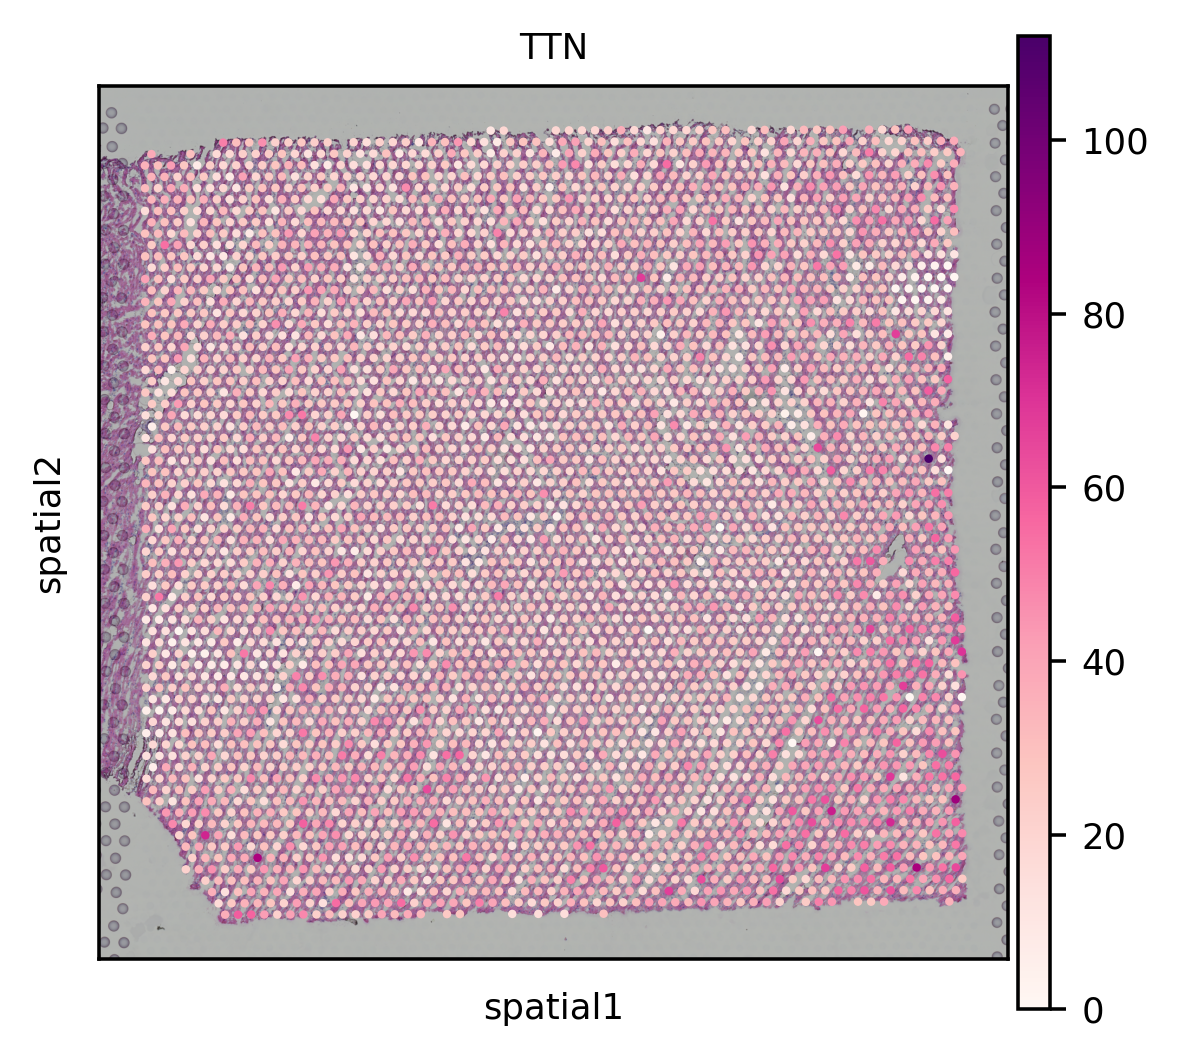

In [9]:
sc.pl.spatial(adata_vis, color = ['TTN'])

- Remove mitochondrial genes for downstream analysis

In [10]:
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var_names]
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
adata_vis

View of AnnData object with n_obs × n_vars = 4247 × 36588
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'MT_gene'
    uns: 'spatial'
    obsm: 'spatial', 'MT'

### Load scRNA-Seq reference

In [11]:
adata_ref = sc.read_h5ad('/home/cartalop/data/carlos/single_cell/heart/regions/LV/HHH_LV_Litvinukova20_ctl230114.raw.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 99487 × 15744
    obs: 'domain_label', 'cell_states'

In [12]:
adata_ref.X = adata_ref.X.astype('int')

- Check if `anndata.X` is raw

In [13]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [14]:
X_is_raw(adata_ref)

True

### Select informative genes in reference for deconvolutrion

/home/cartalop/mambaforge/envs/c2l/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


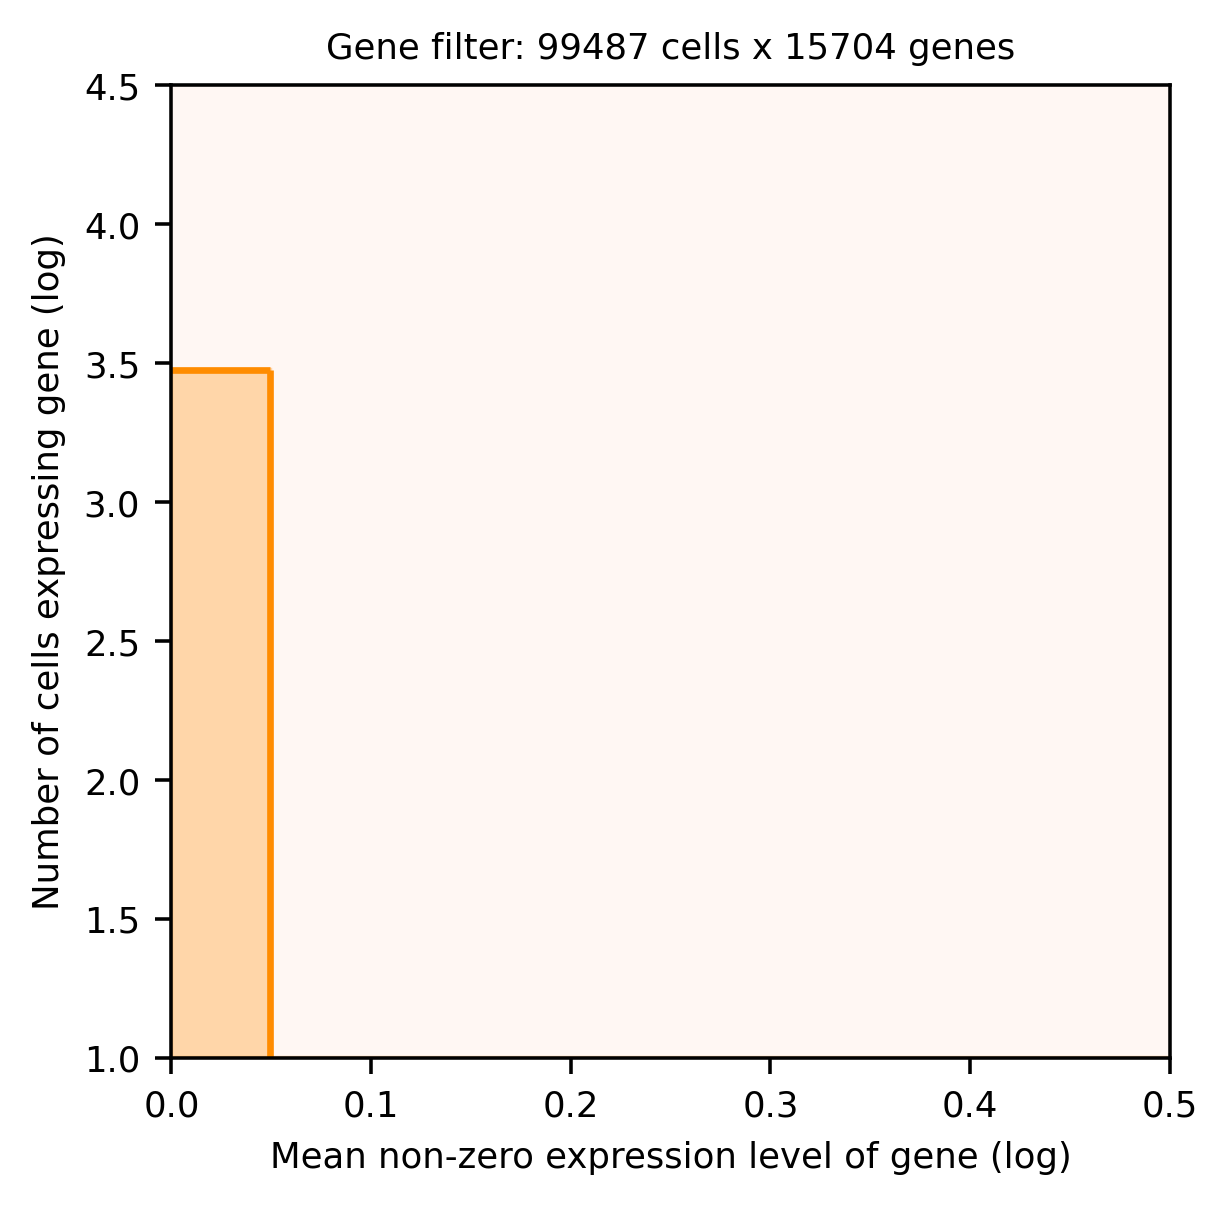

In [15]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff = 5, cell_percentage_cutoff2 = 0.03, nonz_mean_cutoff = 1.12)

- Filter object using these genes

In [16]:
adata_ref = adata_ref[:, selected].copy()
adata_ref

AnnData object with n_obs × n_vars = 99487 × 15704
    obs: 'domain_label', 'cell_states'
    var: 'n_cells', 'nonz_mean'

In [17]:
adata_ref.obs['cell_states'].value_counts()

vCM1             29024
PC1_vent         14276
FB1               6781
EC1_cap           6032
vCM3              5708
                 ...  
unclassfied.2        5
CD4+T_Tfh            4
NC5                  2
NC6                  2
CD4+T_Th17           1
Name: cell_states, Length: 74, dtype: int64

### Estimation of reference cell type signatures (NB regression)

In [18]:

from cell2location.models import RegressionModel

RegressionModel.setup_anndata(
    adata = adata_ref,
    batch_key = 'domain_label',
    labels_key = 'cell_states'
)
mod = RegressionModel(adata_ref)
mod.view_anndata_setup()

/home/cartalop/mambaforge/envs/c2l/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 9 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'domain_label',
│   'labels_key': 'cell_states',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  27   │
│         n_cells          │ 99487 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  74   │
│          n_vars          │ 15704 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                           batch State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃      Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['domain_label'] │    train_H0015_LV     │          0          │
│                           │    train_H0020_LV     │          1          │
│                           │    train_H0025_LV     │          2          │
│                           │   train_H0026_LV_V3   │          3          │
│                           │    train_H0035_LV     │          4          │
│                           │    train_H0037_LV     │          5          │
│                           │ train_HCAHeart7656534 │          6          │
│                           │ train_HCAHeart7664652 │          7          │
│                           │ train_HCAHeart7664653 │          8          │
│                           │ train_HCAHeart7664654 │          9          │
│                           │ train_HCAHeart7698015 │         10          │
│                           │ train_HCAHeart7702873 │         11          │
│                           │ train_HCAHeart7728604 │         12          │
│                           │ train_HCAHeart7745966 │         13          │
│                           │ train_HCAHeart7757636 │         14          │
│                           │ train_HCAHeart7829978 │         15          │
│                           │ train_HCAHeart7835148 │         16          │
│                           │ train_HCAHeart7843999 │         17          │
│                           │ train_HCAHeart7850539 │         18          │
│                           │ train_HCAHeart7850545 │         19          │
│                           │ train_HCAHeart7880860 │         20          │
│                           │ train_HCAHeart7888922 │         21          │
│                           │ train_HCAHeart7905327 │         22          │
│                           │ train_HCAHeart7985086 │         23          │
│                           │ train_HCAHeart8102859 │         24          │
│                           │ train_HCAHeart8102865 │         25          │
│                           │ train_HCAHeart8287124 │         26          │
└───────────────────────────┴───────────────────────┴─────────────────────┘

                      labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_states'] │     Adip1     │          0          │
│                          │     Adip2     │          1          │
│                          │     Adip3     │          2          │
│                          │     Adip4     │          3          │
│                          │       B       │          4          │
│                          │   B_plasma    │          5          │
│                          │   CD4+T_Tfh   │          6          │
│                          │   CD4+T_Th1   │          7          │
│                          │   CD4+T_Th2   │          8          │
│                          │  CD4+T_Th17   │          9          │
│                          │   CD4+T_act   │         10          │
│                          │  CD4+T_naive  │         11          │
│                          │   CD4+T_reg   │         12          │
│                          │  CD8+T_cytox  │         13          │
│                          │   CD8+T_em    │         14          │
│                          │   CD8+T_te    │         15          │
│                          │  CD8+T_trans  │         16          │
│                          │    CD14+Mo    │         17          │
│                          │    CD69+Mo    │         18          │
│                          │ Cycling_T/NK  │         19          │
│                          │      DC2      │         20          │
│                          │   DOCK4+aMØ   │         21          │
│                          │   DOCK4+vMØ   │         22          │
│                          │    EC1_cap    │         23          │
│                          │    EC2_cap    │         24          │
│                          │    EC3_cap    │         25          │
│                          │  EC4_immune   │         26          │
│                          │    EC5_art    │         27          │
│                          │    EC6_ven    │         28          │
│                          │   EC7_atria   │         29          │
│                          │    EC8_ln     │         30          │
│                          │  EC9_FB-like  │         31          │
│                          │ EC10_CMC-like │         32          │
│                          │      FB1      │         33          │
│                          │      FB2      │         34          │
│                          │      FB3      │         35          │
│                          │      FB4      │         36          │
│                          │      FB5      │         37          │
│                          │      FB6      │         38          │
│                          │      ILC      │         39          │
│                          │   LYVE1+MØ1   │         40          │
│                          │   LYVE1+MØ2   │         41          │
│                          │     M2MØ      │         42          │
│                          │   MAIT-like   │         43          │
│                          │     Mast      │         44          │
│                          │     Meso      │         45          │
│                          │     MoMø      │         46          │
│                          │      NC1      │         47          │
│                          │      NC2      │         48          │
│                          │      NC3      │         49          │
│                          │      NC4      │         50          │
│                          │      NC5      │         51          │
│                          │      NC6      │         52          │
│                          │   NK_CD16hi   │         53          │
│                          │   NK_CD56hi   │         54          │
│                          │      NØ       │   

In [19]:
mod.train(
    max_epochs = 250,
    batch_size = 2500,
    train_size = 1,
    lr = 0.002,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cartalop/mambaforge/envs/c2l/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [23:30<00:00,  5.63s/it, v_num=1, elbo_train=6.57e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [23:30<00:00,  5.64s/it, v_num=1, elbo_train=6.57e+8]


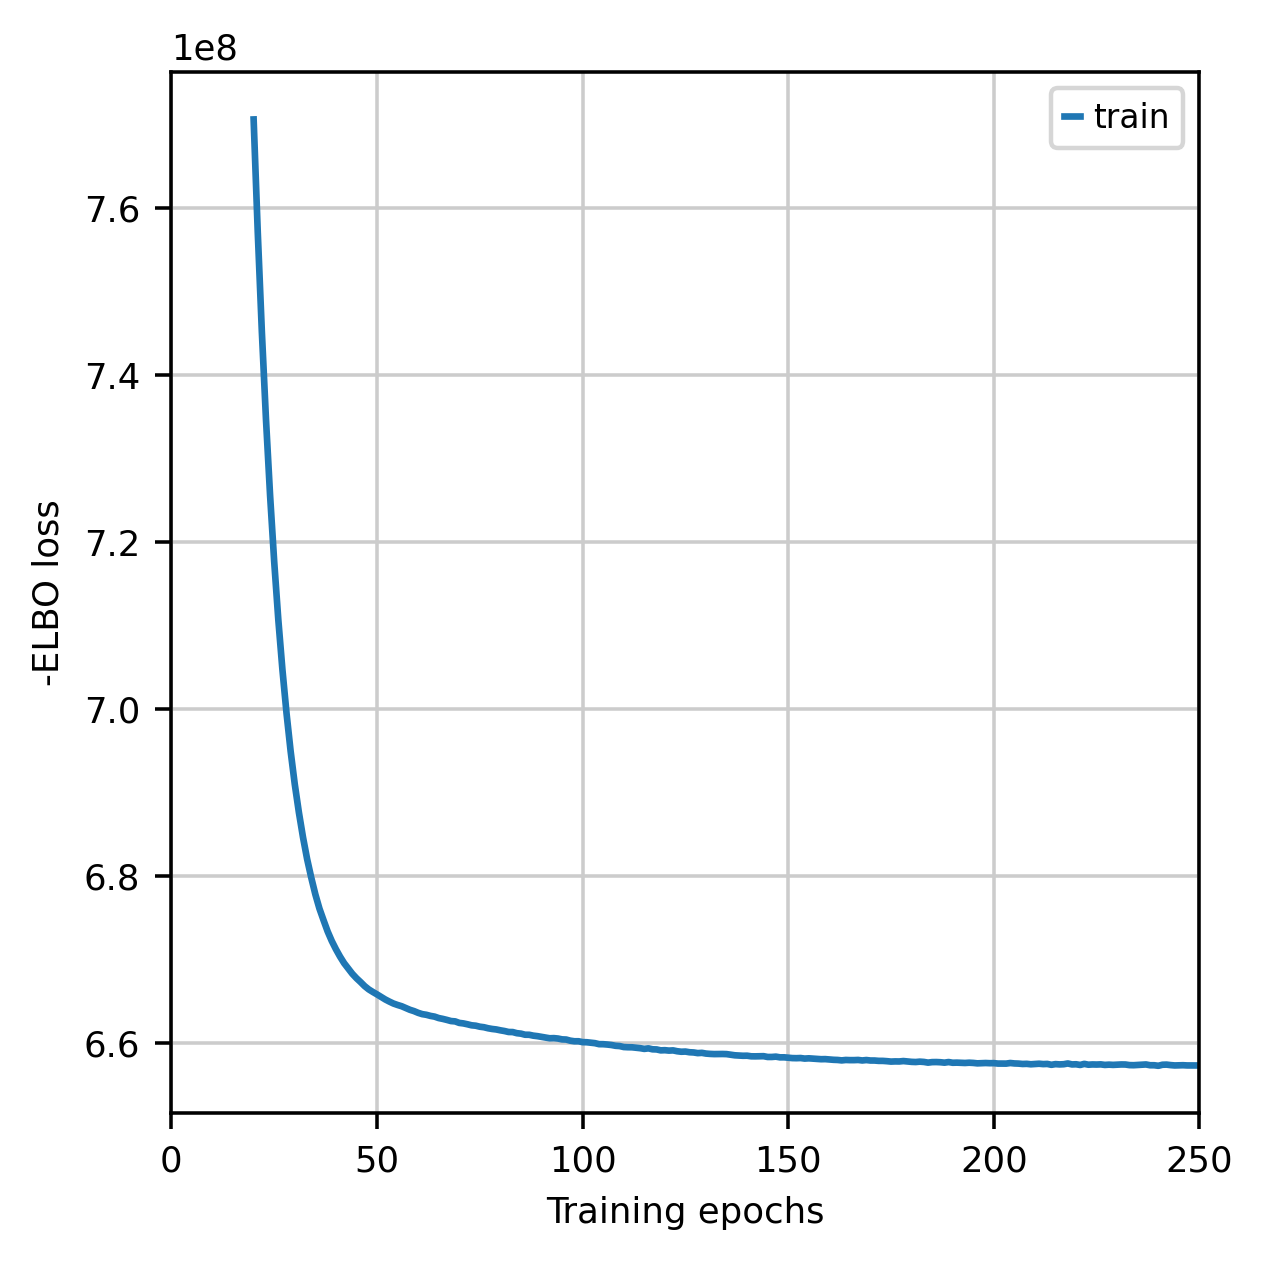

In [20]:
mod.plot_history(20)

### Export cell type abundance estimates

In [21]:
adata_ref = mod.export_posterior(
    adata_ref,
    sample_kwargs = {
        'num_samples': 1000,
        'batch_size': 2500,
        'use_gpu': True
    },
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:07<00:00, 132.83it/s]


### Save model

In [22]:
mod.save(f"{ref_run_name}", overwrite = True)

### Save up annotated Visium object

In [23]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

'/home/cartalop/data/carlos/single_cell/autotalker/public_datasets/10x_heart_lv/c2l/reference_signatures/sc.h5ad'

### Evaluate model QC

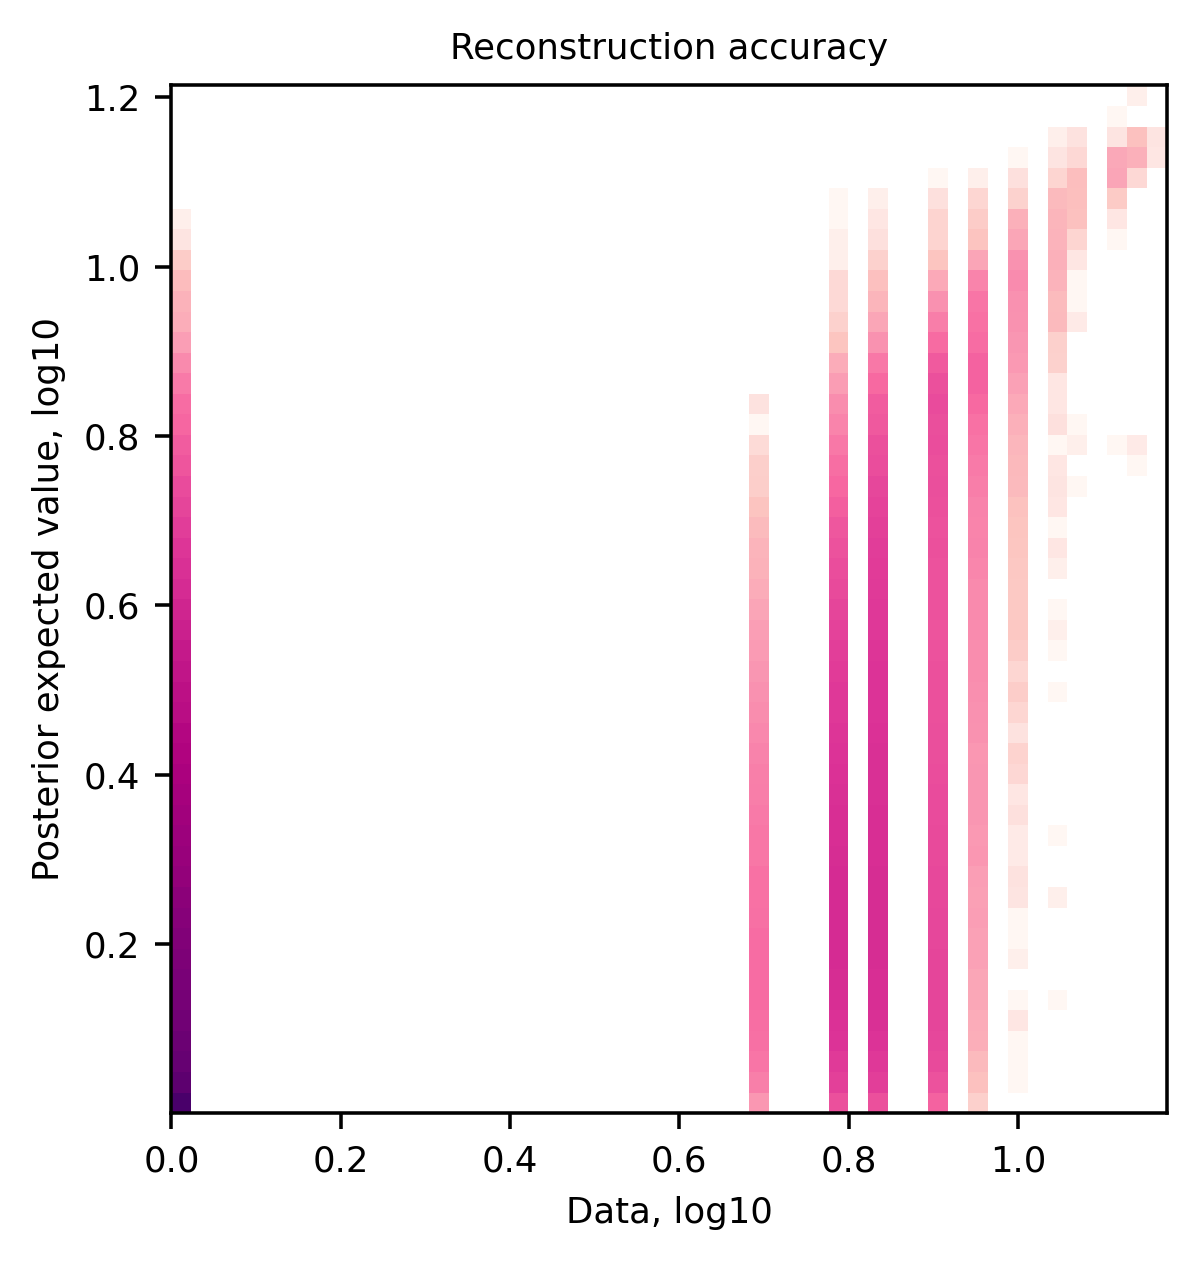

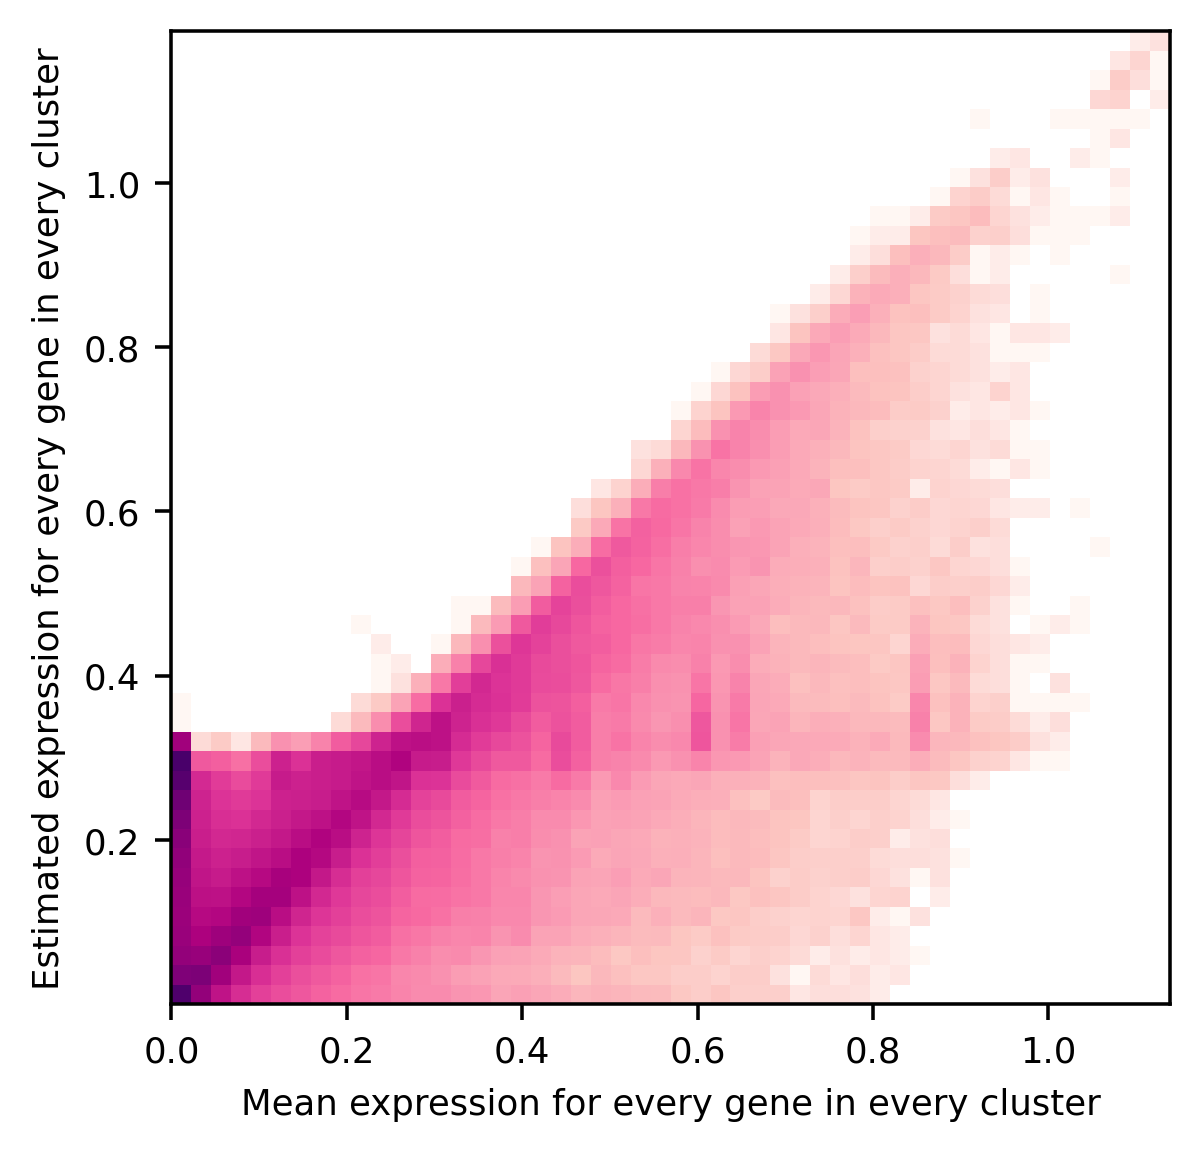

In [24]:
mod.plot_QC()

### Extract reference cell types signatures as a `pandas` dataframe

In [25]:
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Adip1,Adip2,Adip3,Adip4,B
FAM87B,1.003887,0.991258,0.927478,0.961903,0.964141
LINC00115,0.585857,0.906203,1.004164,0.950229,0.813350
FAM41C,0.940590,0.962505,1.002191,1.043327,0.904114
SAMD11,0.896769,0.999473,0.926829,0.978509,0.997017
NOC2L,0.630358,1.099492,1.017959,0.966415,0.289594


### Spatial mapping with `cell2location`

- Find shared genes and subset both anndata and reference signatures

['FAM87B',
 'LINC00115',
 'FAM41C',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'HES4',
 'ISG15',
 'AGRN',
 'C1orf159',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'UBE2J2',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20',
 'ANKRD65',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'SSU72',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'SLC35E2B',
 'CDK11A',
 'NADK',
 'GNB1',
 'TMEM52',
 'PRKCZ',
 'SKI',
 'MORN1',
 'RER1',
 'PEX10',
 'PLCH2',
 'PANK4',
 'HES5',
 'TNFRSF14',
 'MMEL1',
 'TTC34',
 'PRDM16',
 'ARHGEF16',
 'MEGF6',
 'TPRG1L',
 'WRAP73',
 'TP73',
 'CCDC27',
 'SMIM1',
 'LRRC47',
 'CEP104',
 'DFFB',
 'C1orf174',
 'LINC01134',
 'AJAP1',
 'NPHP4',
 'KCNAB2',
 'CHD5',
 'RPL22',
 'RNF207',
 'ICMT',
 'GPR153',
 'ACOT7',
 'HES2',
 'ESPN',
 'TNFRSF25',
 'PLEKHG5',
 'NOL9',
 'TAS1R1',
 'ZBTB48',
 'KLHL21',
 'PHF13',
 'THAP3',
 'DNAJC11',
 'CAMTA1',
 'VAMP3',
 'PER3',
 'UTS2',
 'TNFRSF9',
 'PARK7',
 'ERRFI1',
 'SLC45A1',
 'RERE',
 'ENO1',
 'ENO1-AS1',
 'C

In [34]:
intersect = np.intersect1d(list(dict.fromkeys(adata_vis.var_names)), list(dict.fromkeys(inf_aver.index)))
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
from cell2location.models import Cell2location
Cell2location.setup_anndata(adata = adata_vis, batch_key = "sample")

mod = Cell2location(
    adata_vis, cell_state_df = inf_aver,
    N_cells_per_location = 30,
    detection_alpha = 200
)
mod.view_anndata_setup()

mod.train(
    max_epochs = 30000,
    batch_size = None,
    train_size = 1,
)

- Plot ELBO loss history during training, removing first 100 epochs from the plot

In [ ]:
mod.plot_history(1000)
plt.legend(labels = ['full data training']);

### Exporting estimated posterior distributions of cell abundance and saving results

In [ ]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs = {'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

In [ ]:
mod.save(f"{run_name}", overwrite = True)

### Save `anndata` object with results

In [ ]:
adata_file = f"{run_name}/6332STDY9479172_c2l_ctl221206.h5ad"
adata_vis.write(adata_file)
adata_file

In [ ]:
mod.plot_QC()

In [ ]:
fig = mod.plot_spatial_QC_across_batches()

### Visualising cell abundance in spatial coordinates

- Add 5% quantile, representing confident cell abundance, 'at least this amount is present', to `adata.obs` with cell names for plotting

In [ ]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

In [ ]:
#from cell2location.utils import select_slide
#slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

slide = adata_vis.copy()

In [ ]:
slide

In [ ]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    colors = ['Alveolar macrophages', 'Alveolar fibroblasts', 'Classical monocytes', 'Ionocyte', 'Basal resting', 'Multiciliated', 'Tuft', 'Suprabasal']
    sc.pl.spatial(
        slide,
        cmap = 'magma',
        # show first 8 cell types
        color = colors,
        ncols = 4,
        size = 1.3,
        img_key = 'hires',
        # limit color scale at 99.2% quantile of cell abundance
        vmin = 0,
        vmax = 'p99.2'
    )

### Plot multiple cell types in one panel

In [ ]:
from cell2location.plt import plot_spatial

clust_labels = ['Alveolar macrophages', 'Alveolar fibroblasts', 'Classical monocytes', 'Ionocyte']
clust_col = ['' + str(i) for i in clust_labels]

with mpl.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(
        adata = slide,
        color = clust_col, labels = clust_labels,
        show_img = True,
        style = 'fast',
        max_color_quantile = 0.992,
        circle_diameter = 6,
        colorbar_position = 'right'
    )

In [ ]:
slide